In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Read a pandas DataFrame
data = pd.read_csv('AAPL.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
0,2016-01-04,25.65,26.34,25.50,26.34,24.44,270597600,0.070389,1133.0
1,2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0
2,2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0
3,2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0
4,2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0


In [14]:
from sklearn.preprocessing import MinMaxScaler

data['ts_polarity'] = data['ts_polarity'].interpolate()
data['twitter_volume'] = data['twitter_volume'].interpolate()

# Select features for the model
features = data[['Open', 'High', 'Low', 'Adj Close', 'ts_polarity', 'twitter_volume']]
target = data['Close']

In [15]:
# Normalize features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1,1))

In [16]:
import numpy as np

# Helper function to create sequences
def create_dataset(features, target, look_back=30):
    dataX, dataY = [], []
    for i in range(len(features) - look_back):
        a = features[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(target[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Create dataset for LSTM
X, y = create_dataset(scaled_features, scaled_target)

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, trainY = X[0:train_size], y[0:train_size]
testX, testY = X[train_size:], y[train_size:]

trainX.shape, trainY.shape, testX.shape, testY.shape

((926, 30, 6), (926,), (232, 30, 6), (232,))

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build the LSTM model
model = Sequential([
    Bidirectional(LSTM(512, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)), input_shape=(trainX.shape[1], trainX.shape[2])),
    Dropout(0.2),
    BatchNormalization(),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(128),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=1, callbacks=[early_stop])

Epoch 1/20
29/29 [==============================] - 7s 75ms/step - loss: 20.5055 - val_loss: 11.9095
Epoch 2/20
29/29 [==============================] - 1s 29ms/step - loss: 7.7642 - val_loss: 5.4897
Epoch 3/20
29/29 [==============================] - 1s 29ms/step - loss: 3.8500 - val_loss: 3.3597
Epoch 4/20
29/29 [==============================] - 1s 30ms/step - loss: 2.3304 - val_loss: 2.3228
Epoch 5/20
29/29 [==============================] - 1s 29ms/step - loss: 1.5218 - val_loss: 1.6841
Epoch 6/20
29/29 [==============================] - 1s 30ms/step - loss: 1.0307 - val_loss: 1.2683
Epoch 7/20
29/29 [==============================] - 1s 30ms/step - loss: 0.7160 - val_loss: 0.9637
Epoch 8/20
29/29 [==============================] - 1s 30ms/step - loss: 0.5083 - val_loss: 0.7786
Epoch 9/20
29/29 [==============================] - 1s 31ms/step - loss: 0.3673 - val_loss: 0.6177
Epoch 10/20
29/29 [==============================] - 1s 31ms/step - loss: 0.2703 - val_loss: 0.5269
Epoch 1

1/1 [==============================] - 1s 1s/step


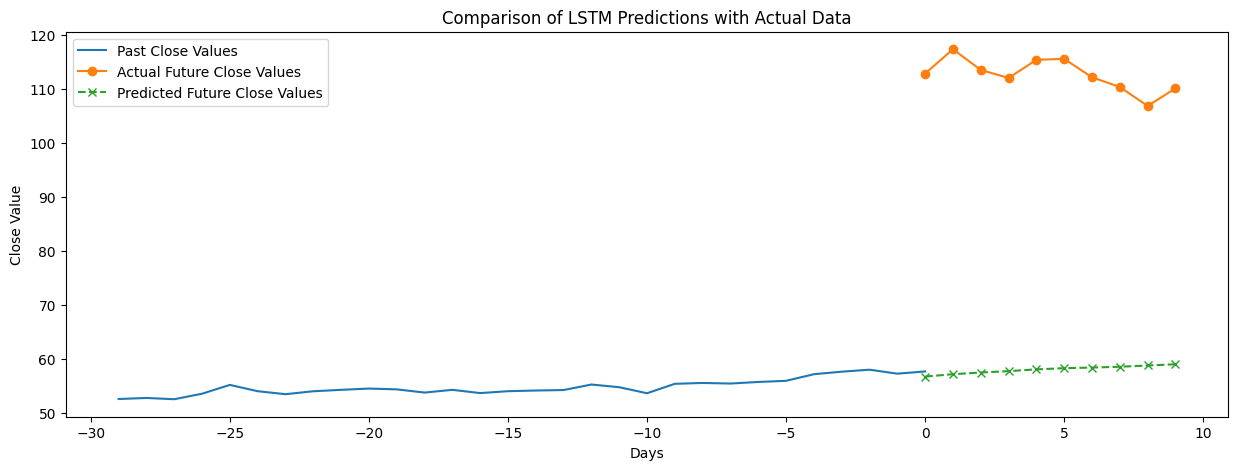

In [28]:
last_sequence = testX[-10:,:,:]
predicted_output = model.predict(last_sequence)
predicted_output = scaler_target.inverse_transform(predicted_output)
actual_output = scaler_target.inverse_transform(testY[-10:].reshape(-1, 1))

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(range(-29, 1), scaler_target.inverse_transform(trainX[-1][:, 0].reshape(-1, 1)), label='Past Close Values')
plt.plot(range(0, 10), actual_output, marker='o', label='Actual Future Close Values')
plt.plot(range(0, 10), predicted_output, marker='x', linestyle='--', label='Predicted Future Close Values')
plt.title('Comparison of LSTM Predictions with Actual Data')
plt.xlabel('Days')
plt.ylabel('Close Value')
plt.legend()
plt.show()